In [1]:
%matplotlib inline

import torch
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
import scipy.io as sio

In [2]:
# Cargar el archivo MAT
emnist_digits = sio.loadmat('emnist-digits.mat')

In [3]:
# cargamos las caracteristicas de emnist de entrenamiento
X_train = emnist_digits["dataset"]["train"][0][0]["images"][0][0]
#X_train = X_train[:1000]
print("Shape X_train: ", X_train.shape)
# cargamos las etiquetas de emnist de entrenamiento
y_train = emnist_digits["dataset"]["train"][0][0]["labels"][0][0]
#y_train[y_train == 26] = 0
print("Shape y_train: ", y_train.shape)

# cargamos las caracteristicas de emnist de prueba
X_test = emnist_digits["dataset"]["test"][0][0]["images"][0][0]
print("Shape X_test: ", X_test.shape)
# cargamos las etiquetas de emnist de prueba
y_test = emnist_digits["dataset"]["test"][0][0]["labels"][0][0]
#y_test[y_test == 26] = 0
print("Shape y_test: ", y_test.shape)

Shape X_train:  (240000, 784)
Shape y_train:  (240000, 1)
Shape X_test:  (40000, 784)
Shape y_test:  (40000, 1)


In [4]:
# normalizamos las caracteristicas
X_train = X_train / 255.0
X_test = X_test / 255.0
X_train = np.array(X_train)
X_test = np.array(X_test)

In [5]:
# mostramos las clases
print('y_train clases: ', np.unique(y_train))
print('y_test clases: ', np.unique(y_test))

y_train clases:  [0 1 2 3 4 5 6 7 8 9]
y_test clases:  [0 1 2 3 4 5 6 7 8 9]


c:\Users\israe\anaconda3\lib\site-packages\matplotlib\text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


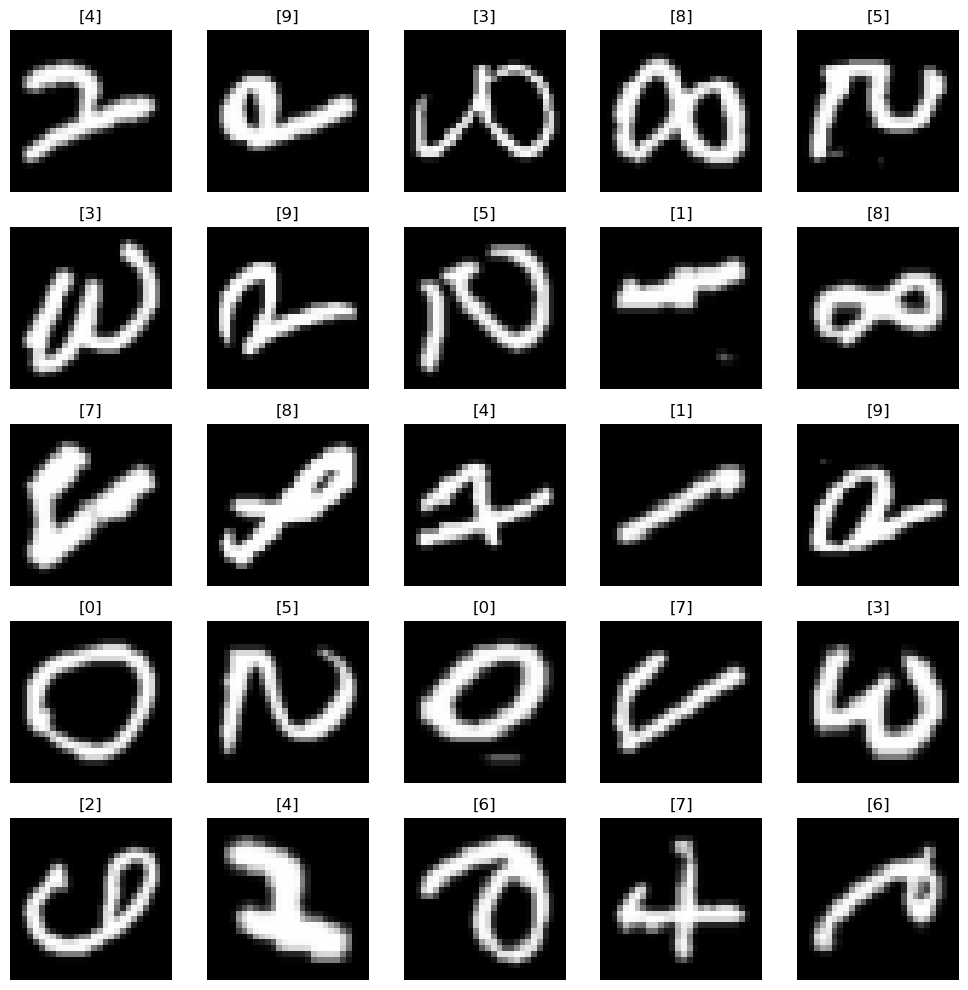

In [6]:
r, c = 5, 5
fig = plt.figure(figsize=(2*c, 2*r))
for _r in range(r):
    for _c in range(c):
        plt.subplot(r, c, _r*c + _c + 1)
        ix = random.randint(0, len(X_train)-1)
        img = X_train[ix]
        plt.imshow(img.reshape(28,28), cmap='gray')
        plt.axis("off")
        plt.title(y_train[ix])
plt.tight_layout()
plt.show()

In [7]:
# función de pérdida y derivada
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum(axis=-1, keepdims=True)
    
def cross_entropy(output, target):
    logits = output[torch.arange(len(output)), target]
    loss = - logits + torch.log(torch.sum(torch.exp(output), axis=-1))
    loss = loss.mean()
    return loss

In [8]:
D_in, H, D_out = 784, 100, 26

# pesos del MLP (copiamos en gpu)
w1 = torch.tensor(np.random.normal(loc=0.0,
          scale = np.sqrt(2/(D_in+H)),
          size = (D_in, H)), requires_grad=True, dtype=torch.float).cuda()
b1 = torch.zeros(H, requires_grad=True, dtype=torch.float).cuda()

w2 = torch.tensor(np.random.normal(loc=0.0,
          scale = np.sqrt(2/(D_out+H)),
          size = (H, D_out)), requires_grad=True, dtype=torch.float).cuda()
b2 = torch.zeros(D_out, requires_grad=True, dtype=torch.float).cuda()

# convertimos datos a tensores y copiamos en gpu
X_t = torch.from_numpy(X_train).float().cuda()
Y_t = torch.from_numpy(y_train).long().cuda()

epochs = 100
lr = 0.8
log_each = 10
l = []
for e in range(1, epochs+1):

    # forward
    h = X_t.mm(w1) + b1
    h_relu = h.clamp(min=0) # relu
    y_pred = h_relu.mm(w2) + b2

    # loss
    loss = cross_entropy(y_pred, Y_t)
    l.append(loss.item())

    # Backprop (calculamos todos los gradientes automáticamente)
    loss.backward()

    with torch.no_grad():
        # update pesos
        w1 -= lr * w1.grad
        b1 -= lr * b1.grad
        w2 -= lr * w2.grad
        b2 -= lr * b2.grad

        # ponemos a cero los gradientes para la siguiente iteración
        # (sino acumularíamos gradientes)
        w1.grad.zero_()
        w2.grad.zero_()
        b1.grad.zero_()
        b2.grad.zero_()

    if not e % log_each:
        print(f"Epoch {e}/{epochs} Loss {np.mean(l):.5f}")

OutOfMemoryError: CUDA out of memory. Tried to allocate 429.15 GiB (GPU 0; 12.00 GiB total capacity; 936.27 MiB already allocated; 10.04 GiB free; 948.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [9]:
torch.cuda.empty_cache()

In [ ]:
def evaluate(x):
    h = x.mm(w1) + b1
    h_relu = h.clamp(min=0)
    y_pred = h_relu.mm(w2) + b2
    y_probas = softmax(y_pred)
    return torch.argmax(y_probas, axis=1)

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = evaluate(torch.from_numpy(X_test).float().cuda())
accuracy_score(y_test, y_pred.cpu().numpy())

0.034326923076923074

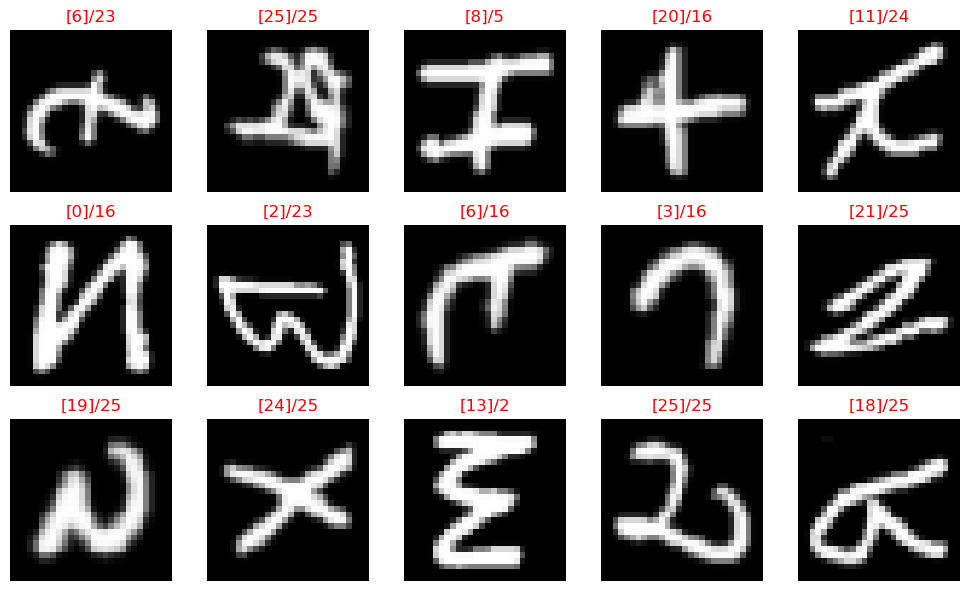

In [ ]:
r, c = 3, 5
fig = plt.figure(figsize=(2*c, 2*r))
test_imgs, test_labs = [], []
for _r in range(r):
    for _c in range(c):
        plt.subplot(r, c, _r*c + _c + 1)
        ix = random.randint(0, len(X_test)-1)
        img = X_test[ix]
        y_pred = evaluate(torch.tensor([img]).float().cuda())[0]
        plt.imshow(img.reshape(28,28), cmap='gray')
        plt.axis("off")
        plt.title(f"{y_test[ix]}/{y_pred}", color="green" if y_test[ix] == y_pred else "red")
plt.tight_layout()
plt.show()